In [ ]:
# To get the training dataframe, run the Training DF construction ipynb
import pandas as pd
final_df = pd.read_csv('training_dataframe.csv', index_col=0)

# Random Forest
In this section we trained the model as a Random Forest. It was useful to try out the idea, and it was used for determining the importance of each feature.

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# GRID SEARCH FOR RANDOM FOREST TUNING
def tune_random_forest(X, y, cv=5):
    # Define parameter grid
    param_grid = {
        # Number of trees in the forest
        'n_estimators': [100, 200, 300, 500],

        'criterion': ["gini", "entropy", "log_loss"],
        
        # Maximum depth of each tree
        'max_depth': [None, 10, 20],
        
        # Minimum samples required to split a node
        'min_samples_split': [2, 5, 10],
        
        # Minimum samples required at each leaf node
        'min_samples_leaf': [1, 2, 4],
        
        # Maximum number of features to consider for splits
        'max_features': ['sqrt', 'log2'],
        
        # Whether bootstrap samples are used
        #'bootstrap': [True, False]
    }
    
    # Initialize Random Forest
    rf = RandomForestClassifier(random_state=42)
    
    # Perform grid search
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=cv,
        n_jobs=-1,
        scoring='f1',
        verbose=1
    )
    
    # Fit the grid search
    grid_search.fit(X, y)
    
    # Get the best parameters and score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    # Get feature importances from the best model
    feature_importance = pd.DataFrame({
        'feature': [f'Feature_{i}' for i in range(X.shape[1])],
        'importance': grid_search.best_estimator_.feature_importances_
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    return {
        'best_parameters': best_params,
        'best_score': best_score,
        'feature_importance': feature_importance,
        'cv_results': pd.DataFrame(grid_search.cv_results_)
    }

In [4]:
final_df = final_df.sample(frac=1, random_state=42)
y = final_df["is_answer"]
X = final_df.drop("is_answer", axis="columns")

In [5]:
tune_random_forest(X,y)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


{'best_parameters': {'criterion': 'gini',
  'max_depth': 20,
  'max_features': 'sqrt',
  'min_samples_leaf': 4,
  'min_samples_split': 2,
  'n_estimators': 200},
 'best_score': 0.8958927863424311,
 'feature_importance':      feature  importance
 5  Feature_5    0.409152
 2  Feature_2    0.216867
 1  Feature_1    0.196085
 3  Feature_3    0.079535
 0  Feature_0    0.078368
 4  Feature_4    0.019993,
 'cv_results':      mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
 0         1.124481      0.029528         0.031874        0.004696   
 1         2.224421      0.047920         0.059464        0.004386   
 2         3.453228      0.113039         0.096709        0.015279   
 3         6.110429      0.062718         0.136547        0.007512   
 4         1.197079      0.030543         0.029552        0.001681   
 ..             ...           ...              ...             ...   
 643       6.024531      0.081197         0.117722        0.009790   
 644       1.243243     

In [6]:
rf_model = RandomForestClassifier(random_state=42,
                            criterion= 'gini',
                            max_depth= 20,
                            max_features= 'sqrt',
                            min_samples_leaf= 4,
                            min_samples_split= 2,
                            n_estimators= 200)
rf_model.fit(X,y)

RandomForestClassifier(max_depth=20, min_samples_leaf=4, n_estimators=200,
                       random_state=42)

In [7]:
col_order = ['graph_traverser', 'page_similarity_score', 'parent_similarity_score','entity_similarity_score', 'n_relevant_entities', 'similarity_score']

print("FEATURE IMPORTANCES")
feature_importance = rf_model.feature_importances_

for i in range(6):
  print(f"{col_order[i]}: {round(feature_importance[i],5)}")

FEATURE IMPORTANCES
graph_traverser: 0.07837
page_similarity_score: 0.19608
parent_similarity_score: 0.21687
entity_similarity_score: 0.07954
n_relevant_entities: 0.01999
similarity_score: 0.40915


# Neural Network

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm

In [ ]:
import pandas as pd
final_df = pd.read_csv('training_dataframe.csv', index_col=0)

In [ ]:
final_df.head()

,graph_traverser,page_similarity_score,parent_similarity_score,entity_similarity_score,n_relevant_entities,similarity_score,is_answer
130850,0,-0.245684,-4.524805,-4.524805,0,-4.524805,0
462661,0,-0.431245,-4.467841,-4.467841,0,-4.467841,0
367632,0,-4.230712,-4.230712,-0.425809,1,-4.230712,0
308468,0,0.176157,-4.528001,-4.528001,0,-4.528001,1
322238,0,-4.533956,-4.533956,-4.533956,0,0.030432,0


In [ ]:
y = final_df["is_answer"]
X = final_df.drop("is_answer", axis="columns")
y.to_csv('y.csv')
X.to_csv('X.csv')

In [ ]:
inputs = keras.Input((X.shape[1],))

x = inputs

x = keras.layers.Dense(254, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)

        # Second hidden layer
x = keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.3)(x)

        # Second hidden layer
x = keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.4)(x)

        # Output layer
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
net = keras.Model(inputs, outputs)

In [ ]:
net.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy'])

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

history = net.fit(
        X, y,
        epochs=100,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stopping,reduce_lr],
        verbose=1
    )

Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8191 - loss: 2.7577 - val_accuracy: 0.7778 - val_loss: 1.7331 - learning_rate: 0.0010
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8554 - loss: 1.4169 - val_accuracy: 0.8391 - val_loss: 0.9888 - learning_rate: 0.0010
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8603 - loss: 0.8475 - val_accuracy: 0.8563 - val_loss: 0.6693 - learning_rate: 0.0010
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8643 - loss: 0.6047 - val_accuracy: 0.8691 - val_loss: 0.4971 - learning_rate: 0.0010
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8660 - loss: 0.4876 - val_accuracy: 0.8683 - val_loss: 0.4371 - learning_rate: 0.0010
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8715 - loss: 0.4299 - val_accuracy: 0.8683 - val_loss: 0.4108 - learning_rate: 0.0010
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8714 - loss: 0

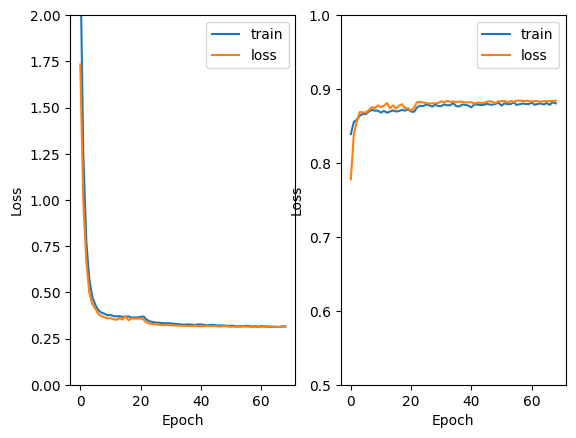

In [ ]:
import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','loss'])

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','loss'])

In [ ]:
col_order = ['graph_traverser', 'page_similarity_score', 'parent_similarity_score','entity_similarity_score', 'n_relevant_entities', 'similarity_score']

In [ ]:
import json

# To get the test data run Training DF contrustion ipynb
with open('test_data.json', 'r') as file:
    test_data = json.load(file)

In [ ]:
hybrid_precision = []
hybrid_recall = []
hybrid_detection = []

for question in tqdm(test_data):
    observations = question["observations"]
    # Check how many answers in total
    tot_answer = len([x for x in observations.values() if x.get("is_answer", 0) == 1])

    # Hybrid RAG retrieval: find top 3 chunks
    subset = pd.DataFrame(observations.values()).drop("is_answer", axis="columns")[col_order]
    results = [x[0] for x in net.predict(subset, verbose=0)]
    top_indexes = sorted(range(len(results)), key=lambda k: results[k], reverse=True)[:3]
    keys = [list(observations.keys())[x] for x in top_indexes]
    # Check how many of them cointain the answer
    found_answers = len([x for x in keys if observations[x].get("is_answer", 0) == 1])
    # Append results for Chunk RAG
    hybrid_precision.append(found_answers/3)
    hybrid_recall.append(found_answers/tot_answer)
    hybrid_detection.append(min(found_answers, 1))

100%|██████████| 1044/1044 [02:04<00:00,  8.39it/s]


In [ ]:
print("PRECISION:")
print(f"Chunk RAG: 0.24")
print(f"Hybrid RAG (FFNN naive sampling) before: 0.28")
print(f"Hybrid RAG (FFNN naive sampling) now: {round(sum(hybrid_precision)/len(hybrid_precision),2)}")
print("")
print("RECALL:")
print(f"Chunk RAG: 0.53")
print(f"Hybrid RAG (FFNN naive sampling) before: 0.63")
print(f"Hybrid RAG (FFNN naive sampling) now: {round(sum(hybrid_recall)/len(hybrid_recall),2)}")
print("")
print("DETECTION:")
print(f"Chunk RAG: 0.62")
print(f"Hybrid RAG (FFNN naive sampling) before: 0.72")
print(f"Hybrid RAG (FFNN naive sampling) now: {round(sum(hybrid_detection)/len(hybrid_detection),2)}")

PRECISION:
Chunk RAG: 0.24
Hybrid RAG (FFNN naive sampling) before: 0.28
Hybrid RAG (FFNN naive sampling) now: 0.29

RECALL:
Chunk RAG: 0.53
Hybrid RAG (FFNN naive sampling) before: 0.63
Hybrid RAG (FFNN naive sampling) now: 0.65

DETECTION:
Chunk RAG: 0.62
Hybrid RAG (FFNN naive sampling) before: 0.72
Hybrid RAG (FFNN naive sampling) now: 0.74


In [ ]:
net.save("Model.keras")

# Active Subsampling
In this section Active Sampling has been implemented, as described in section 3.2.2 of the Master Thesis.

In [ ]:
import json

# Open and read the JSON file
with open('train_data.json', 'r') as file:
    train_data = json.load(file)

In [ ]:
for el in tqdm(train_data):
  observations = el["observations"]
  subset = pd.DataFrame(observations.values()).drop("is_answer", axis="columns")[col_order]
  results = [x[0] for x in net.predict(subset, verbose=0)]
  top_indexes = sorted(range(len(results)), key=lambda k: results[k], reverse=True)[:int(len(results)/10)]
  i = 0
  for key, value in observations.items():
    value["FF_score"] = results[i]
    if i in top_indexes:
      value["top"] = 1
    else:
      value["top"] = 0
    i += 1

100%|██████████| 4179/4179 [09:12<00:00,  7.56it/s]


In [ ]:
for el in train_data:
  for value in el["observations"].values():
    value["FF_score"] = float(value["FF_score"])

In [ ]:
with open('train_data_with_FFscore.json', 'w') as f:
    json.dump(train_data, f)

In [ ]:
tot_lst = []
for el in train_data:
    tot_lst += list(el["observations"].values())
dataframe = pd.DataFrame(tot_lst)

In [ ]:
new_df = dataframe[dataframe["top"] == 1]
print(f"len(new_df): {len(new_df)}")
print(f"len(is_answer): {len(dataframe[dataframe['is_answer'] == 1])}")

len(new_df): 50167
len(is_answer): 6245


In [ ]:
positive_obs = new_df[new_df["is_answer"] == 1]
num_positive_obs = len(positive_obs)
negative_obs = new_df[new_df["is_answer"] == 0]
negative_obs = negative_obs.sample(num_positive_obs)
final_df = pd.concat([positive_obs, negative_obs])
final_df = final_df.sample(frac=1)
y = final_df["is_answer"]
X = final_df.drop(["is_answer","top", "FF_score"], axis="columns")

In [ ]:
tf.random.set_seed(42)

In [ ]:
inputs = keras.Input((X.shape[1],))

x = inputs

x = keras.layers.Dense(254, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)

        # Second hidden layer
x = keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.3)(x)

        # Second hidden layer
x = keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.4)(x)

        # Output layer
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
smart_net = keras.Model(inputs, outputs)

In [ ]:
smart_net.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy'])

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

history = net.fit(
        X, y,
        epochs=100,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stopping,reduce_lr],
        verbose=1
    )

Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7350 - loss: 0.5717 - val_accuracy: 0.7215 - val_loss: 0.5523 - learning_rate: 1.0000e-04
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7437 - loss: 0.5393 - val_accuracy: 0.7502 - val_loss: 0.5294 - learning_rate: 1.0000e-04
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7411 - loss: 0.5360 - val_accuracy: 0.7483 - val_loss: 0.5268 - learning_rate: 1.0000e-04
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7366 - loss: 0.5300 - val_accuracy: 0.7483 - val_loss: 0.5255 - learning_rate: 1.0000e-04
Epoch 5/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7404 - loss: 0.5306 - val_accuracy: 0.7502 - val_loss: 0.5250 - learning_rate: 1.0000e-04
Epoch 6/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7425 - loss: 0.5228 - val_accuracy: 0.7542 - val_loss: 0.5236 - learning_rate: 1.0000e-04
Epoch 7/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step -

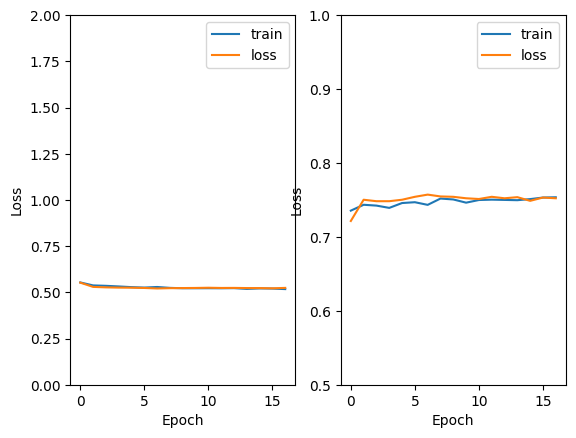

In [ ]:
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','loss'])

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','loss'])

In [ ]:
net.save("Model_with_FFscore.keras")

In [ ]:
hybrid_precision = []
hybrid_recall = []
hybrid_detection = []

for question in tqdm(test_data):
    observations = question["observations"]
    # Check how many answers in total
    tot_answer = len([x for x in observations.values() if x.get("is_answer", 0) == 1])

    # Hybrid RAG retrieval: find top 3 chunks
    subset = pd.DataFrame(observations.values()).drop("is_answer", axis="columns")[col_order]
    results = [x[0] for x in net.predict(subset, verbose=0)]
    top_indexes = sorted(range(len(results)), key=lambda k: results[k], reverse=True)[:3]
    keys = [list(observations.keys())[x] for x in top_indexes]
    # Check how many of them cointain the answer
    found_answers = len([x for x in keys if observations[x].get("is_answer", 0) == 1])
    # Append results for Chunk RAG
    hybrid_precision.append(found_answers/3)
    hybrid_recall.append(found_answers/tot_answer)
    hybrid_detection.append(min(found_answers, 1))

100%|██████████| 1044/1044 [02:30<00:00,  6.95it/s]


In [ ]:
print("PRECISION:")
print(f"Chunk RAG: 0.24")
print(f"Hybrid RAG (FFNN naive): 0.29")
print(f"Hybrid RAG (FFNN smart): {round(sum(hybrid_precision)/len(hybrid_precision),2)}")
print("")
print("RECALL:")
print(f"Chunk RAG: 0.53")
print(f"Hybrid RAG (FFNN naive): 0.65")
print(f"Hybrid RAG (FFNN smart): {round(sum(hybrid_recall)/len(hybrid_recall),2)}")
print("")
print("DETECTION:")
print(f"Chunk RAG: 0.62")
print(f"Hybrid RAG (FFNN naive): 0.74")
print(f"Hybrid RAG (FFNN smart): {round(sum(hybrid_detection)/len(hybrid_detection),2)}")

PRECISION:
Chunk RAG: 0.24
Hybrid RAG (FFNN naive): 0.29
Hybrid RAG (FFNN smart): 0.29

RECALL:
Chunk RAG: 0.53
Hybrid RAG (FFNN naive): 0.65
Hybrid RAG (FFNN smart): 0.65

DETECTION:
Chunk RAG: 0.62
Hybrid RAG (FFNN naive): 0.74
Hybrid RAG (FFNN smart): 0.75


# Variable Selection

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm

## Remove Graph Traverser and number of relevant entities

In [8]:
X = pd.read_csv('X.csv', index_col=0)[["page_similarity_score", "parent_similarity_score", "entity_similarity_score", "similarity_score"]]
y = pd.read_csv('y.csv', index_col=0)

In [7]:
tf.random.set_seed(42)

In [8]:
inputs = keras.Input((X.shape[1],))

x = inputs

x = keras.layers.Dense(254, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)

        # Second hidden layer
x = keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.3)(x)

        # Second hidden layer
x = keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.4)(x)

        # Output layer
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
net = keras.Model(inputs, outputs)

In [9]:
net.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy'])

In [10]:
early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

history = net.fit(
        X, y,
        epochs=100,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stopping,reduce_lr],
        verbose=1
    )

Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.8146 - loss: 2.7207 - val_accuracy: 0.8303 - val_loss: 1.6704 - learning_rate: 0.0010
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8484 - loss: 1.3909 - val_accuracy: 0.8663 - val_loss: 0.9495 - learning_rate: 0.0010
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8514 - loss: 0.8609 - val_accuracy: 0.8735 - val_loss: 0.6461 - learning_rate: 0.0010
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8591 - loss: 0.6182 - val_accuracy: 0.8727 - val_loss: 0.4965 - learning_rate: 0.0010
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8573 - loss: 0.5054 - val_accuracy: 0.8723 - val_loss: 0.4345 - learning_rate: 0.0010
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8604 - loss: 0.4510 - val_accuracy: 0.8735 - val_loss: 0.4029 - learning_rate: 0.0010
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8595 - loss: 

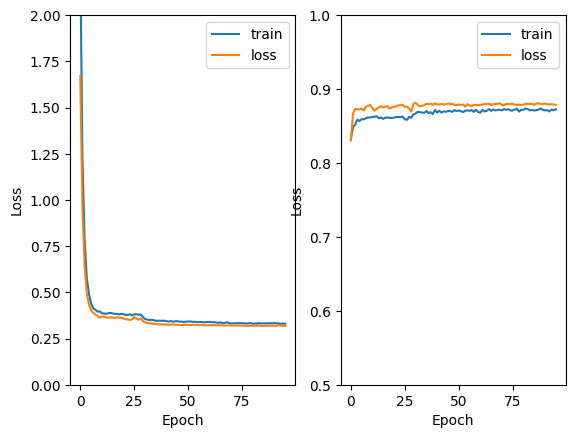

In [11]:
import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','loss'])

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','loss'])

In [12]:
col_order = ['page_similarity_score', 'parent_similarity_score','entity_similarity_score', 'similarity_score']

In [18]:
import json

# Open and read the JSON file
with open('test_data.json', 'r') as file:
    test_data = json.load(file)

In [19]:
hybrid_precision = []
hybrid_recall = []
hybrid_detection = []

for question in tqdm(test_data):
    observations = question["observations"]
    # Check how many answers in total
    tot_answer = len([x for x in observations.values() if x.get("is_answer", 0) == 1])

    # Hybrid RAG retrieval: find top 3 chunks
    subset = pd.DataFrame(observations.values()).drop("is_answer", axis="columns")[col_order]
    results = [x[0] for x in net.predict(subset, verbose=0)]
    top_indexes = sorted(range(len(results)), key=lambda k: results[k], reverse=True)[:3]
    keys = [list(observations.keys())[x] for x in top_indexes]
    # Check how many of them cointain the answer
    found_answers = len([x for x in keys if observations[x].get("is_answer", 0) == 1])
    # Append results for Chunk RAG
    hybrid_precision.append(found_answers/3)
    hybrid_recall.append(found_answers/tot_answer)
    hybrid_detection.append(min(found_answers, 1))

100%|██████████| 1044/1044 [02:01<00:00,  8.58it/s]


In [20]:
print("PRECISION:")
print(f"Chunk RAG: 0.24")
print(f"Hybrid RAG (FFNN naive sampling) before removing: 0.29")
print(f"Hybrid RAG (FFNN naive sampling) after removing: {round(sum(hybrid_precision)/len(hybrid_precision),2)}")
print("")
print("RECALL:")
print(f"Chunk RAG: 0.53")
print(f"Hybrid RAG (FFNN naive sampling) before removing: 0.65")
print(f"Hybrid RAG (FFNN naive sampling) after removing: {round(sum(hybrid_recall)/len(hybrid_recall),2)}")
print("")
print("DETECTION:")
print(f"Chunk RAG: 0.62")
print(f"Hybrid RAG (FFNN naive sampling) before removing: 0.74")
print(f"Hybrid RAG (FFNN naive sampling) after removing: {round(sum(hybrid_detection)/len(hybrid_detection),2)}")

PRECISION:
Chunk RAG: 0.24
Hybrid RAG (FFNN naive sampling) before removing: 0.29
Hybrid RAG (FFNN naive sampling) after removing: 0.28

RECALL:
Chunk RAG: 0.53
Hybrid RAG (FFNN naive sampling) before removing: 0.65
Hybrid RAG (FFNN naive sampling) after removing: 0.61

DETECTION:
Chunk RAG: 0.62
Hybrid RAG (FFNN naive sampling) before removing: 0.74
Hybrid RAG (FFNN naive sampling) after removing: 0.71


In [ ]:
net.save("Model.keras")

In [1]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
rf_model = RandomForestClassifier(random_state=42,
                            criterion= 'entropy',
                            max_depth= None,
                            max_features= 'sqrt',
                            min_samples_leaf= 4,
                            min_samples_split= 10,
                            n_estimators= 100)

In [16]:
rf_model.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(criterion='entropy', min_samples_leaf=4,
                       min_samples_split=10, random_state=42)

In [22]:
print("FEATURE IMPORTANCES")
feature_importance = rf_model.feature_importances_

for i in range(4):
  print(f"{col_order[i]}: {round(feature_importance[i],5)}")

FEATURE IMPORTANCES
page_similarity_score: 0.21443
parent_similarity_score: 0.25748
entity_similarity_score: 0.12141
similarity_score: 0.40667


## Remove number of relevant entities only

In [9]:
X = pd.read_csv('X.csv', index_col=0)[["graph_traverser", "page_similarity_score", "parent_similarity_score", "entity_similarity_score", "similarity_score"]]
y = pd.read_csv('y.csv', index_col=0)

In [24]:
tf.random.set_seed(42)

In [25]:
inputs = keras.Input((X.shape[1],))

x = inputs

x = keras.layers.Dense(254, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)

        # Second hidden layer
x = keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.3)(x)

        # Second hidden layer
x = keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.4)(x)

        # Output layer
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
net = keras.Model(inputs, outputs)

In [26]:
net.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy'])

In [27]:
early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

history = net.fit(
        X, y,
        epochs=100,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stopping,reduce_lr],
        verbose=1
    )

Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.8263 - loss: 2.6784 - val_accuracy: 0.8655 - val_loss: 1.6346 - learning_rate: 0.0010
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8505 - loss: 1.3313 - val_accuracy: 0.8711 - val_loss: 0.9185 - learning_rate: 0.0010
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8629 - loss: 0.8003 - val_accuracy: 0.8743 - val_loss: 0.6098 - learning_rate: 0.0010
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8678 - loss: 0.5674 - val_accuracy: 0.8803 - val_loss: 0.4729 - learning_rate: 0.0010
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8692 - loss: 0.4658 - val_accuracy: 0.8779 - val_loss: 0.4201 - learning_rate: 0.0010
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8659 - loss: 0.4230 - val_accuracy: 0.8707 - val_loss: 0.4015 - learning_rate: 0.0010
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8695 - loss: 

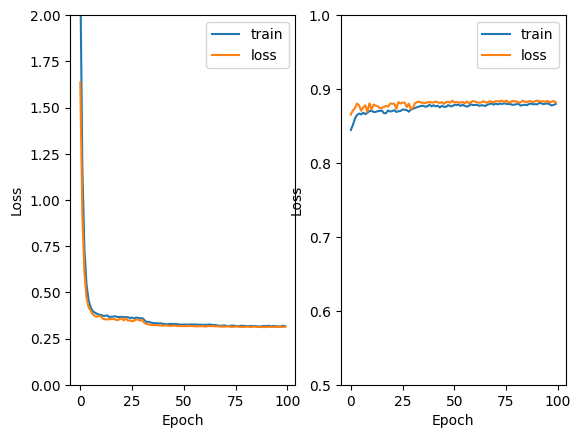

In [28]:
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','loss'])

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','loss'])

In [11]:
col_order = ['graph_traverser', 'page_similarity_score', 'parent_similarity_score','entity_similarity_score', 'similarity_score']

In [30]:
hybrid_precision = []
hybrid_recall = []
hybrid_detection = []

for question in tqdm(test_data):
    observations = question["observations"]
    # Check how many answers in total
    tot_answer = len([x for x in observations.values() if x.get("is_answer", 0) == 1])

    # Hybrid RAG retrieval: find top 3 chunks
    subset = pd.DataFrame(observations.values()).drop("is_answer", axis="columns")[col_order]
    results = [x[0] for x in net.predict(subset, verbose=0)]
    top_indexes = sorted(range(len(results)), key=lambda k: results[k], reverse=True)[:3]
    keys = [list(observations.keys())[x] for x in top_indexes]
    # Check how many of them cointain the answer
    found_answers = len([x for x in keys if observations[x].get("is_answer", 0) == 1])
    # Append results for Chunk RAG
    hybrid_precision.append(found_answers/3)
    hybrid_recall.append(found_answers/tot_answer)
    hybrid_detection.append(min(found_answers, 1))

100%|██████████| 1044/1044 [01:33<00:00, 11.12it/s]


In [31]:
print("PRECISION:")
print(f"Chunk RAG: 0.24")
print(f"Hybrid RAG (FFNN naive sampling) before removing: 0.29")
print(f"Hybrid RAG (FFNN naive sampling) after removing: {round(sum(hybrid_precision)/len(hybrid_precision),2)}")
print("")
print("RECALL:")
print(f"Chunk RAG: 0.53")
print(f"Hybrid RAG (FFNN naive sampling) before removing: 0.65")
print(f"Hybrid RAG (FFNN naive sampling) after removing: {round(sum(hybrid_recall)/len(hybrid_recall),2)}")
print("")
print("DETECTION:")
print(f"Chunk RAG: 0.62")
print(f"Hybrid RAG (FFNN naive sampling) before removing: 0.74")
print(f"Hybrid RAG (FFNN naive sampling) after removing: {round(sum(hybrid_detection)/len(hybrid_detection),2)}")

PRECISION:
Chunk RAG: 0.24
Hybrid RAG (FFNN naive sampling) before removing: 0.29
Hybrid RAG (FFNN naive sampling) after removing: 0.29

RECALL:
Chunk RAG: 0.53
Hybrid RAG (FFNN naive sampling) before removing: 0.65
Hybrid RAG (FFNN naive sampling) after removing: 0.65

DETECTION:
Chunk RAG: 0.62
Hybrid RAG (FFNN naive sampling) before removing: 0.74
Hybrid RAG (FFNN naive sampling) after removing: 0.75


In [32]:
net.save("Model_without_n_rel_entities.keras")

In [10]:
rf_model = RandomForestClassifier(random_state=42,
                            criterion= 'gini',
                            max_depth= 20,
                            max_features= 'sqrt',
                            min_samples_leaf= 4,
                            min_samples_split= 2,
                            n_estimators= 200)
rf_model.fit(X,y)

/Users/dgiardini002/.pyenv/versions/3.10.10/envs/ai-coe-blueprint/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(max_depth=20, min_samples_leaf=4, n_estimators=200,
                       random_state=42)

In [12]:
print("FEATURE IMPORTANCES")
feature_importance = rf_model.feature_importances_

for i in range(5):
  print(f"{col_order[i]}: {round(feature_importance[i],5)}")

FEATURE IMPORTANCES
graph_traverser: 0.06468
page_similarity_score: 0.16661
parent_similarity_score: 0.25278
entity_similarity_score: 0.09384
similarity_score: 0.42209
